# Libraries:

In [1]:
import numpy as np  
from numpy import linalg as LA
import pandas as pd  
import statsmodels.api as sm 
from matplotlib import pyplot as plt
import random
import seaborn as sns; sns.set_theme()
from scipy.optimize import nnls
from google.colab import data_table
from statsmodels.tools.eval_measures import rmse

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading relevant datasets:



In [2]:
#Loading ballots 2021:
url = 'https://raw.githubusercontent.com/danshabo/Lab1-3rd-Year-/main/votes%20per%20city%202021.csv'
df_2021_raw = pd.read_csv(url,  encoding = 'iso-8859-8', index_col='שם ישוב')
url2 = 'https://raw.githubusercontent.com/danshabo/Lab1-3rd-Year-/main/votes%20per%20ballot%202021.csv'
df_2021_ballot_raw = pd.read_csv(url2,  encoding = 'iso-8859-8', index_col='שם ישוב')
#Loading ballots 2020:
url2020 = 'https://raw.githubusercontent.com/pepaloma/Lab-3rd-Year/main/votes%20per%20city%202020.csv'
df_2020_raw = pd.read_csv(url2020,  encoding = 'iso-8859-8', index_col='שם ישוב')
url20202 = 'https://raw.githubusercontent.com/pepaloma/Lab-3rd-Year/main/votes%20per%20ballot%202020.csv'
df_2020_ballot_raw = pd.read_csv(url20202,  encoding = 'iso-8859-8', index_col='שם ישוב')
url_eshkol = 'https://raw.githubusercontent.com/danshabo/Lab1-3rd-Year-/0f66617cb06880b33fc51f6be273c38b8f094b7c/eshkol_hevrati_calcali.csv'
hevrati = pd.read_csv(url_eshkol, encoding = 'iso-8859-8', index_col='name')
#Ballot dfs cleaning:
b21 = df_2021_ballot_raw.drop(['מעטפות חיצוניות'])
b21 = b21.drop(b21.columns[len(b21.columns) - 1],axis=1)
b20 = df_2020_ballot_raw.drop(['מעטפות חיצוניות'])
b20 = b20.drop(b20.columns[len(b20.columns) - 1],axis=1)
b21_p = b21.iloc[:,10:].sum().div(b21.iloc[:,10:].sum().sum()).sort_values(ascending=False)[0:13]
b20_p = b20.iloc[:,10:].sum().div(b20.iloc[:,10:].sum().sum()).sort_values(ascending=False)[0:9]


ballots_merged = b20.merge(b21, on=['קלפי','שם ישוב',], how='inner',suffixes=('_20', '_21'))# (4115 , 88)
party_votes_merged = ballots_merged.loc[:, ~ballots_merged.columns.isin(['סמל ישוב_20	', 'קלפי', 'ריכוז_20', 'שופט_20', 'בזב_20'
, 'מצביעים_20', 'פסולים_20', 'כשרים_20', 'סמל ישוב_21', 'קלפי_21', 'ריכוז_21', 'סמל ישוב_21', 'שופט_21', 'בזב_21', 'מצביעים_21', 'פסולים_21', 'כשרים_21','סמל ועדה_20','סמל ועדה_21','ברזל_20','ברזל_21'])]
party_votes_merged = party_votes_merged.iloc[:,1:]

#Getting the right range for each year in the merged dataframe:
b20_names = party_votes_merged.iloc[:,0:30]
b21_names = party_votes_merged.iloc[:,30:]




# Question 1:

We are asked to calculate the top 13 parties for 2021, and the top 9 parties for 2020, so Im going to create Nij for each year:

In [3]:

top13_21 = b21_names.sum().div(b21_names.sum().sum()).sort_values(ascending=False)[0:13]
top9_20 = b20_names.sum().div(b20_names.sum().sum()).sort_values(ascending=False)[0:9]
Nij_20 = b20_names[top9_20.keys()]
Nij_21 = b21_names[top13_21.keys()]
Nij_20 #(4115, 9)
Nij_21 #(4115, 13)
model = sm.OLS(Nij_21, Nij_20).fit()
M_matrix = model.params
names_20 = ['מחל','פה','שס','ל','אמת','טב','ודעם','ג','נץ']
M_matrix.columns = b21_p.index.values
M_matrix.index = names_20
M_matrix = M_matrix.T
M_matrix


,מחל,פה,שס,ל,אמת,טב,ודעם,ג,נץ
מחל,0.770767,-0.002748,0.008603,-0.030986,-0.002434,-0.113850,0.029398,-0.025813,-0.217624
פה,-0.007965,0.498495,-0.015320,0.129435,-0.196289,-0.004897,-0.002319,0.006500,-0.008591
שס,0.016686,0.245991,0.000685,-0.069988,-0.048131,0.000895,-0.004226,-0.001140,-0.080139
כן,0.002406,-0.005217,0.854540,-0.002776,0.016390,-0.003729,0.001281,-0.006170,-0.248321
ג,-0.024184,0.088943,0.013450,-0.014971,0.667649,0.005063,-0.005236,-0.004654,0.136190
אמת,0.075063,0.050578,-0.019751,-0.022757,-0.038771,0.501903,-0.001934,0.004013,-1.087748
ב,0.004897,0.019047,-0.003025,0.724724,0.005437,-0.007507,-0.000066,0.001648,0.042408
ל,0.001799,-0.028192,0.062889,-0.008539,0.014555,0.618045,-0.000288,0.034701,3.465890
ודעם,-0.030554,0.035997,0.012776,-0.006868,0.664703,-0.003261,0.015785,-0.002544,0.071373
ט,0.064695,0.091952,-0.024578,0.051746,-0.080352,0.030976,0.001589,0.005700,-0.221719


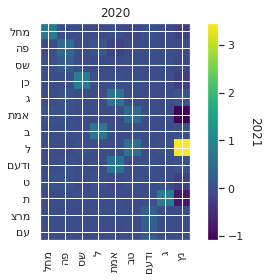

In [4]:
#Plot Func:
def heatmap(matrix):
    names_y = matrix.index.values
    names_x = matrix.columns.values
    rev_names_y = [name[::-1] for name in list(names_y)]
    rev_names_x = [name[::-1] for name in list(names_x)]
    fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap=plt.get_cmap('viridis'))
    n = matrix.shape  # get number of variables 
    ax.set_xticks(np.arange(n[1]))
    ax.set_yticks(np.arange(n[0]))
    plt.xticks(rotation = 90)
    ax.set_xticklabels(rev_names_x)
    ax.set_yticklabels(rev_names_y)
    ax.set_title("2020")
    
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax) #  **cbar_kw)
    cbar.ax.set_ylabel('2021', rotation=-90, va="bottom")

heatmap(M_matrix)

The heatmap after we rearrange the values manually:

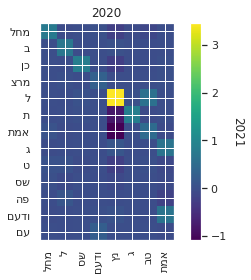

In [5]:
#Sorting the values again so the higher values would be around the diagonal.
names_new_21 = [ 'מחל','ב','כן','מרצ', 'ל', 'ת','אמת','ג','ט','שס', 'פה','ודעם','עם']
names_new_20 = [ 'מחל','ל', 'שס', 'ודעם', 'נץ',  'ג', 'טב', 'אמת']
M_matrix2 = M_matrix.reindex(names_new_20, axis =1)
M_matrix2 = M_matrix2.reindex(names_new_21)
heatmap(M_matrix2)

,מחל,פה,שס,ל,אמת,טב,ודעם,ג,נץ
מחל,0.953014,0.000000,0.010637,0.000000,0.000000,0.000000,0.036349,0.000000,0.000000
פה,0.000000,0.785737,0.000000,0.204018,0.000000,0.000000,0.000000,0.010245,0.000000
שס,0.063522,0.936478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
כן,0.000000,0.000000,0.981181,0.000000,0.018819,0.000000,0.000000,0.000000,0.000000
ג,0.000000,0.097601,0.014759,0.000000,0.732637,0.005555,0.000000,0.000000,0.149447
אמת,0.119613,0.080597,0.000000,0.000000,0.000000,0.799789,0.000000,0.000000,0.000000
ב,0.000000,0.024061,0.000000,0.915499,0.006869,0.000000,0.000000,0.000000,0.053572
ל,0.000000,0.000000,0.014988,0.000000,0.003469,0.147291,0.000000,0.008270,0.825983
ודעם,0.000000,0.044961,0.015957,0.000000,0.830220,0.000000,0.019716,0.000000,0.089146
ט,0.263987,0.375209,0.000000,0.211148,0.000000,0.126396,0.000000,0.023260,0.000000


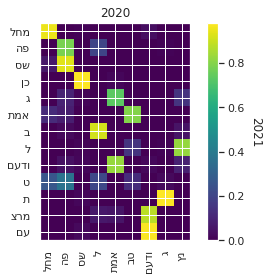

In [6]:
normalized_matrix= M_matrix.copy()
normalized_matrix[normalized_matrix<(0.5/100)]=0


#The new matrix that contains zeros below 0.5% threshold and each row sums to 1:
normalized_matrix.shape #(13, 9)
normalized_matrix.sum(axis=1).shape #(13,)
normalized_matrix = normalized_matrix.T.div(normalized_matrix.sum(axis=1)).T
normalized_matrix.sum(axis=1)
heatmap(normalized_matrix)
normalized_matrix

according to the heatmap above, we can see the Meretz and Haavoda had some exchanges between them, also between haavoda and ra'am. a strange exchange for example is  between Shas and Kahol lavan.

Applying non-negative least squares model for the same setting:

In [7]:
nnls_matrix = pd.DataFrame()
for i in range(len(names_20)):
 x = nnls(Nij_21, Nij_20.iloc[:,i])
 nnls_matrix[names_20[i]] = x[0]
nnls_matrix.index = b21_p.index.values
nnls_matrix

,מחל,פה,שס,ל,אמת,טב,ודעם,ג,נץ
מחל,1.174950,0.000000,0.021953,0.010232,0.015335,0.000000,0.000000,0.000000,0.005738
פה,0.000000,1.073587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
שס,0.000000,1.213810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
כן,0.082556,0.000000,1.054547,0.008139,0.010242,0.000000,0.000000,0.000000,0.008340
ג,0.000000,0.419351,0.000000,0.000000,0.510383,0.000000,0.004557,0.000000,0.001010
אמת,0.162795,0.000000,0.000000,0.000000,0.007723,0.656441,0.000000,0.000000,0.000000
ב,0.095180,0.000000,0.000000,1.151504,0.005843,0.000000,0.000000,0.000937,0.000000
ל,0.140508,0.000000,0.038036,0.000000,0.000000,0.665911,0.000000,0.114271,0.051636
ודעם,0.000000,0.346502,0.000000,0.000000,0.630948,0.000000,0.021521,0.000140,0.000000
ט,0.294303,0.361389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Now we need to repeat section b (0.5% threshold, normalize and sum each row equals 1):


Non Negative Least squares heatmap:


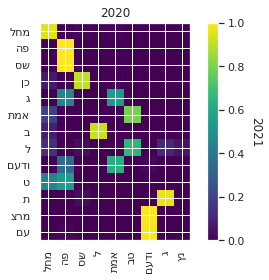

In [8]:
nnls_matrix[nnls_matrix<(0.5/100)]=0
nnls_matrix = nnls_matrix.T.div(nnls_matrix.sum(axis=1)).T
nnls_matrix.sum(axis=1) # Sum rows == 1
nnls_matrix
print("Non Negative Least squares heatmap:")
heatmap(nnls_matrix)


Regular Least squares heatmap: 


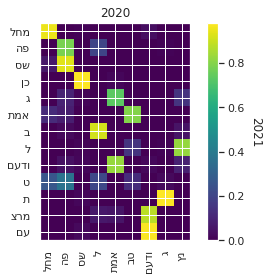

In [9]:
print("Regular Least squares heatmap: ")
heatmap(normalized_matrix)

according to the plots above, we can see a slight difference between the two. it is obvious that the Non Negative Least squares heatmap has some data loss compared to the regular least squares because of the limit of the positive numbers. 

# Question 2:

We need to calculate  (bzb_i - total votes_i) which means, the amount of people who didnt vote in each city.

In [10]:
bzb_20 = ballots_merged["בזב_20"]
bzb_21 = ballots_merged["בזב_21"]
bzb_remains_20 = bzb_20 - Nij_20.sum(axis = 1)
bzb_remains_21 = bzb_21 - Nij_21.sum(axis = 1) #(4115,)
Nij_21_q2 = pd.concat([Nij_21, bzb_remains_21], axis=1, ignore_index=False)
Nij_20_q2 = pd.concat([Nij_20, bzb_remains_20], axis=1, ignore_index=False)
Nij_21_q2.shape #(4115, 14)
Nij_20_q2.shape #(4115, 10)

(4115, 10)

Now after we have the required matricies, We use the OLS again:

In [11]:
model = sm.OLS(Nij_21_q2, Nij_20_q2).fit()
M_matrix_q2 = model.params
names_20 = ['מחל','פה','שס','ל','אמת','טב','ודעם','ג','נץ','בזב20']
names_21_2 = ['מחל', 'פה', 'שס', 'כן', 'ג', 'אמת', 'ב', 'ל', 'ודעם', 'ט', 'ת', 'מרצ','עם','בזב21']
M_matrix_q2.columns = names_21_2
M_matrix_q2.index = names_20
M_matrix_q2 = M_matrix_q2 .T
M_matrix_q2


,מחל,פה,שס,ל,אמת,טב,ודעם,ג,נץ,בזב20
מחל,0.763817,-0.003913,0.005568,-0.053528,-0.016203,-0.114685,0.021767,-0.030664,-0.227375,0.011755
פה,-0.003995,0.499160,-0.013586,0.142314,-0.188422,-0.004419,0.002041,0.009271,-0.003020,-0.006716
שס,0.019889,0.246527,0.002084,-0.059601,-0.041786,0.001279,-0.000710,0.001096,-0.075646,-0.005417
כן,0.005695,-0.004666,0.855977,0.007891,0.022906,-0.003334,0.004892,-0.003875,-0.243707,-0.005563
ג,-0.025105,0.088789,0.013048,-0.017956,0.665825,0.004952,-0.006246,-0.005297,0.134899,0.001557
אמת,0.082163,0.051768,-0.016650,0.000274,-0.024703,0.502757,0.005862,0.008969,-1.077786,-0.012010
ב,-0.005640,0.017281,-0.007627,0.690550,-0.015437,-0.008773,-0.011634,-0.005706,0.027626,0.017821
ל,0.003620,-0.027887,0.063685,-0.002632,0.018164,0.618264,0.001712,0.035973,3.468445,-0.003081
ודעם,-0.032349,0.035696,0.011992,-0.012690,0.661147,-0.003477,0.013814,-0.003797,0.068855,0.003036
ט,0.067680,0.092452,-0.023274,0.061427,-0.074438,0.031334,0.004866,0.007784,-0.217531,-0.005048


Now we're going to normalize the matrix again according to section 2:

Regular Least squares with bzb included: 


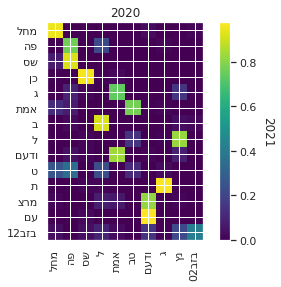

In [12]:
M_matrix_q2[M_matrix_q2<(0.5/100)]=0
M_matrix_q2 = M_matrix_q2.T.div(M_matrix_q2.sum(axis=1)).T
M_matrix_q2
M_matrix_q2.sum(axis=1) # Sum rows == 1
print("Regular Least squares with bzb included: ")
heatmap(M_matrix_q2)

Plot 1b again in order to compare between the two plots:


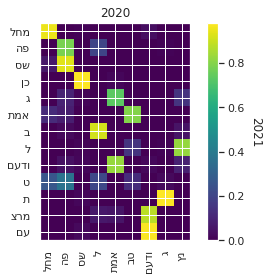

In [13]:
print("Plot 1b again in order to compare between the two plots:")
heatmap(normalized_matrix)

we can see that after we added the row and the column of (bzb_i - total votes_i) for each year, that the volume of the exchanges between most of the parties is pretty much the same. 

# Question 3

We need to compute the residuals' matrix from previous question:

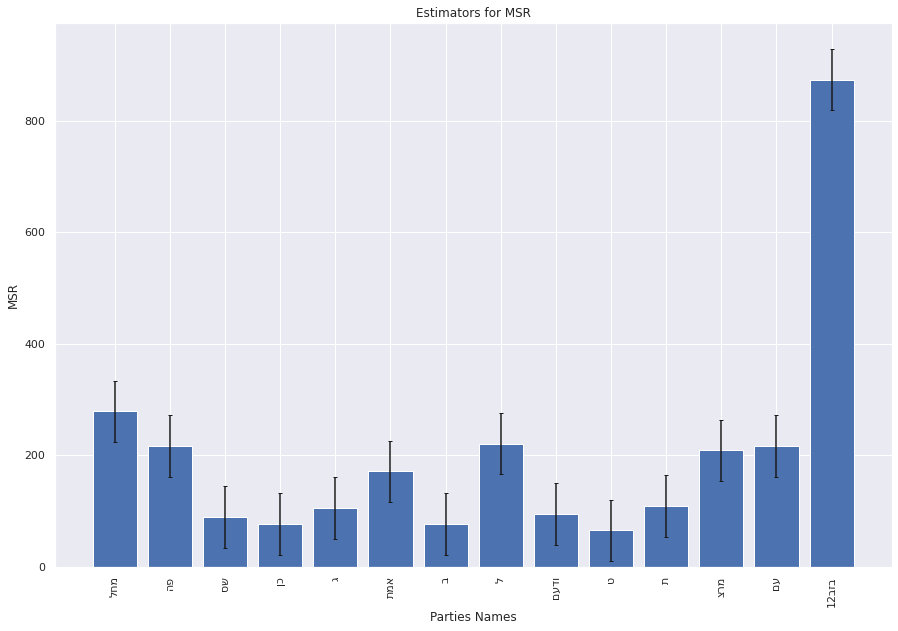

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc2e610a210>)

In [14]:
##
def chart_plot(vector,title,labels):
#define chart 
  std_error = np.std(vector, ddof=1) / np.sqrt(len(vector))
  fig, ax = plt.subplots(figsize=(15,10))
  rev_names = [name[::-1] for name in list(labels)]
  #create chart
  ax.bar(x=np.arange(len(vector)), #x-coordinates of bars
        height=vector, #height of bars
        yerr=std_error, #error bar width
        capsize=2) #length of error bar caps
  ax.set_ylabel(title)
  ax.set_xlabel('Parties Names')
  ax.set_title('Estimators for ' +title)
  ax.set_xticks(np.arange(len(labels)))
  ax.set_xticklabels(rev_names, rotation=90)
  plt.show()
  return fig, ax

chart_plot((model.resid**2).mean(),"MSR",M_matrix_q2.index)

according to the plot above, we can see that the model doesn't predict well when it comes to the bigger parties.In addition, we can see that the model can't predict those who didn't come to vote at all between the to elections, which is the biggest vote loss .

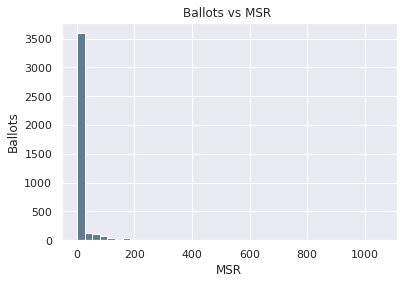

In [15]:
x = (model.resid.mean(axis=1))**2

x.plot.hist(grid=True, bins=40, rwidth=100,
                   color='#607c8e')
plt.title('Ballots vs MSR ')
plt.xlabel('MSR')
plt.ylabel('Ballots')
plt.grid(axis='y', alpha=1)




In [16]:
#Finding top 10 MSR ballots:
top10 = ((model.resid.mean(axis=1))**2)
top10 = pd.DataFrame(top10)
result = pd.concat([top10, ballots_merged['קלפי']], axis=1, ignore_index=False)
result = result.sort_values(by = 0,ascending=False)[0:10]

print(result)



                      0  קלפי
שם ישוב                      
ירוחם       1058.017734   3.0
נחושה       1053.160716   1.0
באר טוביה   1049.819807   1.0
טירת יהודה  1031.348689   1.0
טל שחר      1001.445531   1.0
נס הרים      931.095790   1.0
מגדים        897.354359   1.0
נוף הגליל    839.563471  52.0
עזריה        831.595441   1.0
ירחיב        807.013027   1.0


# Question 4 (Bonus Question):

This time we're going to use Sankey plot to show the voters exchange between elections.

In [17]:
import plotly.graph_objects as go
source = []
target = []
Sankey_M1 = M_matrix.copy()
#Create source:
for i in range(len(Sankey_M1.columns)):
  for j in range(len(Sankey_M1.index)):
    source.append(i)
#Create Target:
for i in range(len(Sankey_M1.columns)):
  for j in range(len(Sankey_M1.index)):
      target.append(j+9)


In [18]:
def sankey(df):
  flat_list = [item for sublist in df.values.tolist() for item in sublist]
  fig = go.Figure(data=[go.Sankey(
      node = dict(
        pad = 60,
        thickness = 20,
        line = dict(color = "black", width = 1),
        label = ['מחל_20', 'פה_20', 'שס_20', 'ל_20', 'אמת_20', 'טב_20', 'ודעם_20',
        'ג_20', 'נץ_20','מחל_21', 'פה_21', 'שס_21', 'כן_21', 'ג_21', 'אמת_21', 'ב_21',
        'ל_21', 'ודעם_21', 'ט_21', 'ת_21', 'מרצ_21', 'עם_21'],
        color = "blue"
      ),
      link = dict(
        source = source, 
        target = target,
        value = flat_list
    ))])
  fig.update_layout(title_text="Votes Exchange", font_size=20)
  fig.show()


For Question 1:

In [19]:

#Flat DF:
Sankey_M1 = M_matrix.copy()
Sankey_M1.columns = [str(col) + '_20' for col in Sankey_M1.columns]
Sankey_M1.index = [str(col) + '_21' for col in Sankey_M1.index]
sankey(M_matrix)


In [20]:
#Flat DF:
Sankey_M1 = normalized_matrix.copy()
Sankey_M1.columns = [str(col) + '_20' for col in Sankey_M1.columns]
Sankey_M1.index = [str(col) + '_21' for col in Sankey_M1.index]
flat_list = [item for sublist in normalized_matrix.values.tolist() for item in sublist]
sankey(normalized_matrix)


for question 2:

In [21]:
#Flat DF:
Sankey_M1 = M_matrix_q2.copy()
Sankey_M1.columns = [str(col) + '_20' for col in Sankey_M1.columns]
Sankey_M1.index = [str(col) + '_21' for col in Sankey_M1.index]
sankey(M_matrix_q2)